# 공공데이터포털 오픈API활용 기상청 지상(종관,ASOS)일자료 조회 

https://www.data.go.kr/data/15059093/openapi.do

## 1) 라이브러리 임포트

In [2]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

## 2) 데이터 전처리

### 2.1) 데이터 타입 변경 및 중복 값 처리

In [12]:
# 원본 데이터 경로
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, '데이터')
data_path = os.path.join(data_dir, r'원본(크롤링)\weather_orig.csv')
print(data_path)

C:\Users\KSH\Documents\크롤링 프로젝트\프로젝트 4조\프로젝트 4조\데이터\원본(크롤링)\weather_orig.csv


In [ ]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, '데이터')
circle_table_path = os.path.join(data_dir, r'전처리\Circle_table.csv')

In [14]:
df = pd.read_csv(data_path, encoding='cp949')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35133 entries, 0 to 35132
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   stnId   35133 non-null  int64  
 1   stnNm   35133 non-null  object 
 2   tm      35133 non-null  object 
 3   avgWs   35038 non-null  float64
 4   avgTa   35076 non-null  float64
 5   sumRn   14407 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.6+ MB


In [14]:
# 날짜 데이터 타입 변경
df.tm = pd.to_datetime(df.tm)

In [16]:
# 중복 값 제거
df = df.drop_duplicates()

In [18]:
len(df)

35133

### 2.2) 결측치처리
1. 자료가 없는 날짜 탐색 후 결측치 처리
2. 자료가 공백인 곳은 관측하지 않은 지점.
3. 강수량의 경우 기상청 예보 비교 결과 강수량이 0인경우에도 자료가 공백.

https://www.weather.go.kr/wnuri_help/html/observation/past-obs.jsp

In [20]:
df.isnull().sum()

stnId        0
stnNm        0
tm           0
avgWs       95
avgTa       57
sumRn    20726
dtype: int64

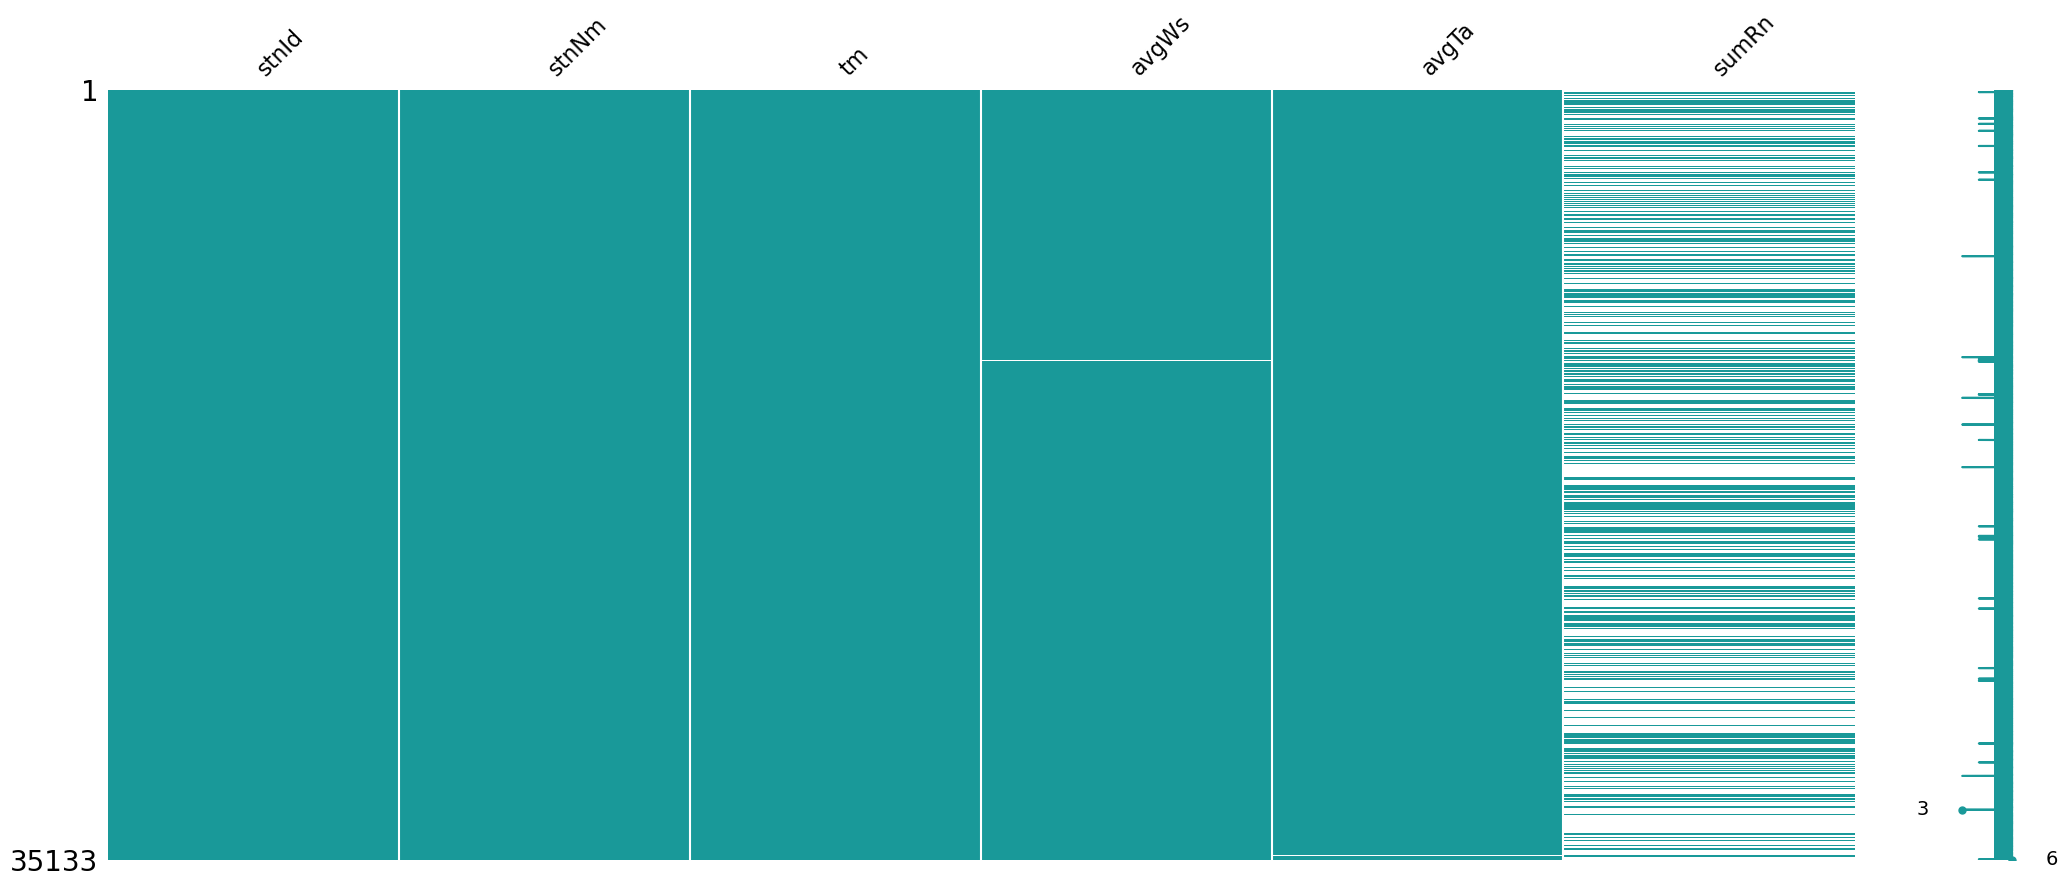

In [22]:
msno.matrix(df, color=(0.1, 0.6, 0.6))
plt.show()

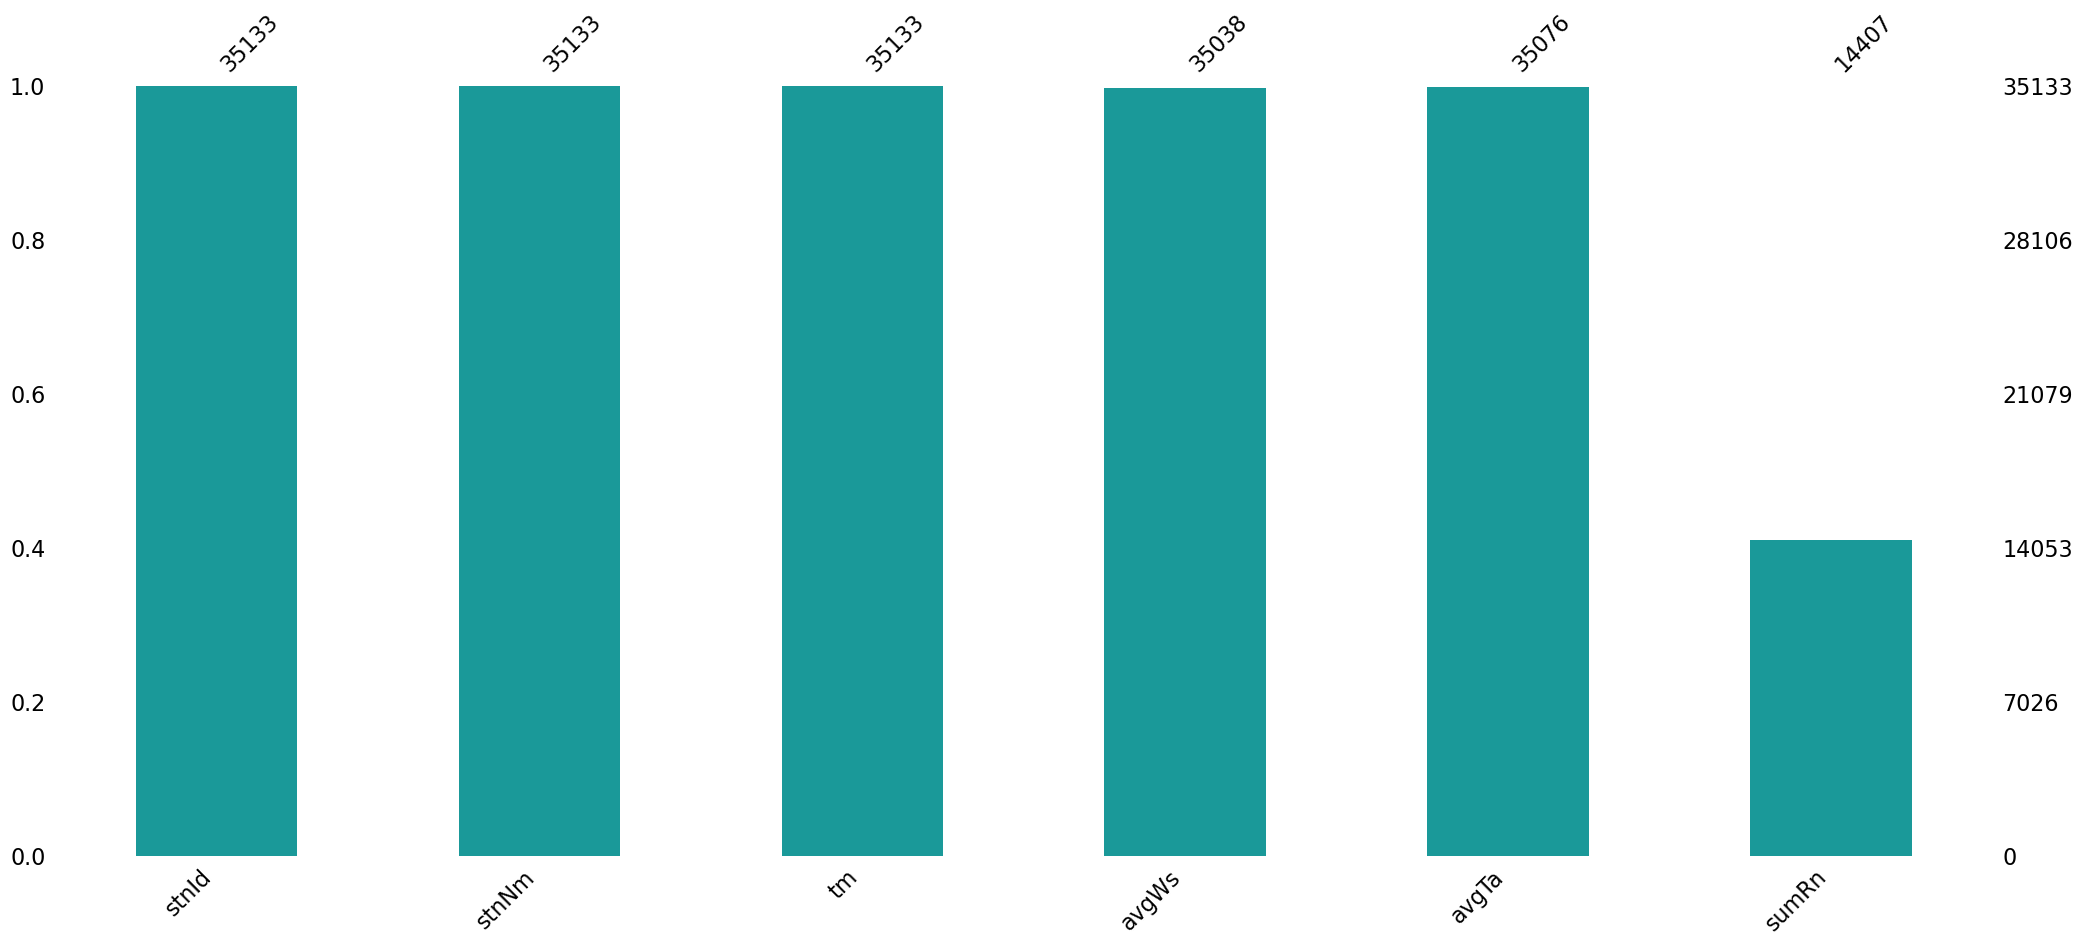

In [24]:
msno.bar(df, color=(0.1, 0.6, 0.6))
plt.show()

In [257]:
''' 
결측치 처리 방법 
1. 날짜는 빠진 날짜 탐색 후 새로운 컬럼 추가 후 정렬 
2. 평균 풍속, 평균 기온은 전일 값으로 채우기
3. 강수량은 0으로 채우기
'''

' \n결측치 처리 방법 \n1. 날짜는 빠진 날짜 탐색 후 새로운 컬럼 추가 후 정렬 \n2. 평균 풍속, 평균 기온은 전일 값으로 채우기\n3. 강수량은 0으로 채우기\n'

#### 2.2.1) 날짜

In [26]:
tm_count = df.groupby(['stnId', 'stnNm'])['tm'].count()
tm_count

stnId  stnNm
90     속초       366
93     북춘천      366
95     철원       366
98     동두천      366
99     파주       366
               ... 
285    합천       366
288    밀양       366
289    산청       366
294    거제       366
295    남해       366
Name: tm, Length: 96, dtype: int64

In [28]:
tm_count.unique()

array([366, 365], dtype=int64)

In [30]:
tm_count = tm_count.to_frame()
missing_tm_stnId = tm_count[tm_count.values==365]
missing_tm_stnId

,,tm
stnId,stnNm,
101,춘천,365
172,고창,365
271,봉화,365


In [32]:
# 빠진 날짜 탐색 후 새로운 컬럼 추가 후 정렬 
for stnId, stnNm in missing_tm_stnId.index:
    date_range = pd.date_range(df[df.stnNm==stnNm]['tm'].min(), df[df.stnNm==stnNm]['tm'].max())
    missing_dates = date_range.difference(df[df.stnNm==stnNm]['tm'])
    missing_data = pd.DataFrame({'stnId':[stnId] * len(missing_dates),
        'stnNm': [stnNm] * len(missing_dates),
        'tm': missing_dates})
    df = pd.concat([df, missing_data], ignore_index=True)
    print(f'{stnNm} 날짜 결측치 : {missing_dates}')

춘천 날짜 결측치 : DatetimeIndex(['2024-12-25'], dtype='datetime64[ns]', freq='D')
고창 날짜 결측치 : DatetimeIndex(['2024-05-20'], dtype='datetime64[ns]', freq='D')
봉화 날짜 결측치 : DatetimeIndex(['2024-08-23'], dtype='datetime64[ns]', freq='D')


In [34]:
# 추가된 데이터 확인 
df[(df.stnNm=='고창')&(df.tm=='2024-05-20')]

,stnId,stnNm,tm,avgWs,avgTa,sumRn
35134,172,고창,2024-05-20,NaN,NaN,NaN


In [36]:
# 날짜 결측치 검증
tm_count = df.groupby('stnNm')['tm'].count()
tm_count.unique()

array([366], dtype=int64)

#### 2.2.2) 평균 풍속 및 평균 기온

In [38]:
df.loc[(pd.isna(df.avgWs))]

,stnId,stnNm,tm,avgWs,avgTa,sumRn
1863,100,대관령,2024-02-03,NaN,-3.5,NaN
1864,100,대관령,2024-02-04,NaN,-2.5,0.0
1880,100,대관령,2024-02-20,NaN,-1.8,4.5
1881,100,대관령,2024-02-21,NaN,-3.7,31.1
1882,100,대관령,2024-02-22,NaN,-6.4,14.3
...,...,...,...,...,...,...
32838,283,경주시,2024-09-24,NaN,NaN,NaN
35100,295,남해,2024-11-29,NaN,7.1,NaN
35133,101,춘천,2024-12-25,NaN,NaN,NaN
35134,172,고창,2024-05-20,NaN,NaN,NaN


In [40]:
df.loc[(pd.isna(df.avgTa))]

,stnId,stnNm,tm,avgWs,avgTa,sumRn
1,90,속초,2024-01-02,1.8,NaN,0.0
95,90,속초,2024-04-05,1.4,NaN,NaN
1296,98,동두천,2024-07-17,1.4,NaN,71.1
1297,98,동두천,2024-07-18,1.0,NaN,NaN
1545,99,파주,2024-03-22,2.7,NaN,1.4
1546,99,파주,2024-03-23,1.2,NaN,NaN
2554,101,춘천,2024-12-24,0.7,NaN,NaN
2555,101,춘천,2024-12-26,1.9,NaN,0.0
3534,105,강릉,2024-08-29,1.8,NaN,40.4
3756,106,동해,2024-04-07,2.3,NaN,NaN


In [42]:
# 평균 풍속, 평균 기온 결측치 전일 값으로 채우기
df[['avgWs', 'avgTa']] = df[['avgWs', 'avgTa']].fillna(method='ffill')

C:\Users\user\AppData\Local\Temp\ipykernel_10840\1575856811.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['avgWs', 'avgTa']] = df[['avgWs', 'avgTa']].fillna(method='ffill')


#### 2.2.3) 강수량

In [44]:
df.loc[(pd.isna(df.sumRn))]

,stnId,stnNm,tm,avgWs,avgTa,sumRn
2,90,속초,2024-01-03,1.6,3.1,NaN
3,90,속초,2024-01-04,1.9,2.9,NaN
4,90,속초,2024-01-05,2.6,7.7,NaN
5,90,속초,2024-01-06,2.1,2.8,NaN
6,90,속초,2024-01-07,2.7,-2.3,NaN
...,...,...,...,...,...,...
35131,295,남해,2024-12-30,1.4,6.7,NaN
35132,295,남해,2024-12-31,1.7,5.5,NaN
35133,101,춘천,2024-12-25,1.7,5.5,NaN
35134,172,고창,2024-05-20,1.7,5.5,NaN


In [46]:
# 강수량은 결측치 0으로 채우기
df['sumRn'] = df['sumRn'].fillna(0)

In [48]:
# 최종 결측치 확인
df.isnull().sum()

stnId    0
stnNm    0
tm       0
avgWs    0
avgTa    0
sumRn    0
dtype: int64

In [50]:
df

,stnId,stnNm,tm,avgWs,avgTa,sumRn
0,90,속초,2024-01-01,1.0,2.7,0.4
1,90,속초,2024-01-02,1.8,2.7,0.0
2,90,속초,2024-01-03,1.6,3.1,0.0
3,90,속초,2024-01-04,1.9,2.9,0.0
4,90,속초,2024-01-05,2.6,7.7,0.0
...,...,...,...,...,...,...
35131,295,남해,2024-12-30,1.4,6.7,0.0
35132,295,남해,2024-12-31,1.7,5.5,0.0
35133,101,춘천,2024-12-25,1.7,5.5,0.0
35134,172,고창,2024-05-20,1.7,5.5,0.0


### 3) EDA

In [52]:
df.describe()

,stnId,tm,avgWs,avgTa,sumRn
count,35136.000000,35136,35136.000000,35136.000000,35136.000000
mean,197.177083,2024-07-01 12:00:00,1.892865,14.673139,3.955556
min,90.000000,2024-01-01 00:00:00,0.100000,-17.500000,0.000000
25%,136.750000,2024-04-01 00:00:00,1.000000,5.900000,0.000000
50%,201.500000,2024-07-01 12:00:00,1.500000,15.500000,0.000000
75%,257.250000,2024-10-01 00:00:00,2.300000,23.500000,0.700000
max,295.000000,2024-12-31 00:00:00,20.200000,33.300000,397.700000
std,64.030526,NaN,1.349127,9.740576,14.777776


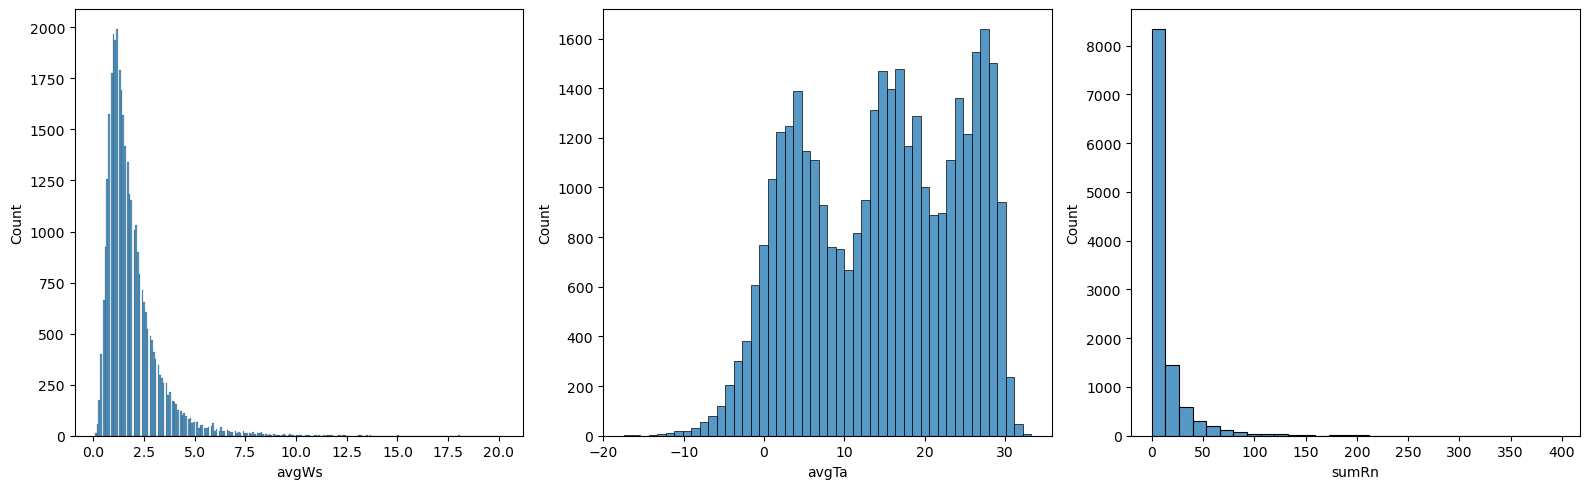

In [54]:
# histplot
temp = df[['avgWs', 'avgTa', 'sumRn']]
plt.figure(figsize=(16,5))
for i in range(len(temp.columns)):    
    plt.subplot(1,3,i+1)
    if i == 2:
        sns.histplot(temp[temp['sumRn'] > 0]['sumRn'], bins=30) # 강수량 0mm 제외
    else:
        sns.histplot(temp.iloc[:,i])
plt.tight_layout()
plt.show()

In [56]:
# correlation
temp = df[['stnId', 'avgWs', 'avgTa', 'sumRn']]
temp = temp.corr()
temp

,stnId,avgWs,avgTa,sumRn
stnId,1.000000,-0.166262,0.027442,0.005872
avgWs,-0.166262,1.000000,-0.077567,0.043900
avgTa,0.027442,-0.077567,1.000000,0.128456
sumRn,0.005872,0.043900,0.128456,1.000000


In [ ]:
# pairplot
temp = df[['stnId', 'avgWs', 'avgTa', 'sumRn']]
sns.pairplot(temp, kind='reg')
plt.show()

In [ ]:
mask = np.array(temp.corr())
mask[np.tril_indices_from(mask)] = False
mask

In [ ]:
temp = df[['stnId', 'avgWs', 'avgTa', 'sumRn']]
plt.figure(figsize=(8,8))
mask = np.array(temp.corr())
mask[np.tril_indices_from(mask)] = False
sns.heatmap(temp.corr(), mask = mask, annot=True, cmap='Blues')
plt.show()
# 대부분의 피어슨 상관계수 값이 0에 가까움 -> Feature 사이의 상관관계는 거의 없음 즉, 선형 독립

### 4) Feature engineering

In [277]:
'''
드론 운행 가능 기상 조건:
1. 강우/강설 : 0
2. 기온 : 0 ~ 40℃
3. 풍속 : 10 m/s 이하
''' 

'\n드론 운행 가능 기상 조건:\n1. 강우/강설 : 0\n2. 기온 : 0 ~ 40℃\n3. 풍속 : 10 m/s 이하\n'

In [278]:
df['tm'].dtype

dtype('<M8[ns]')

In [279]:
min_temp = 0
max_temp = 40
max_ws = 10

def feature_engineering(df, min_temp, max_temp, max_ws):
    df['ws_yn'] = df['avgWs'].map(lambda x: 1 if x<=max_ws else 0)
    df['temp_yn'] = df['avgTa'].map(lambda x: 1 if (x>=min_temp)&(x<=max_temp) else 0)
    df['rain_yn'] = df['sumRn'].map(lambda x: 0 if x>0 else 1)
    df['flight_yn'] = (df['ws_yn'] + df['temp_yn'] + df['rain_yn']).map(lambda x: 1 if x==3 else 0)
    df['yyyymm'] = df['tm'].dt.to_period('M')
    df['days_in_month'] = df['tm'].dt.days_in_month

    
    df_yn = df.groupby(['stnId', 'stnNm', 'yyyymm','days_in_month'])['flight_yn'].sum().reset_index(drop=False)
    df_yn['avg_yn_month'] = df_yn['flight_yn']/df_yn['days_in_month']
    df_yn.columns = [['stnId', 'stnNm', 'yyyymm', 'days_in_month', 'yn_month', 'avg_yn_month']]
    return df, df_yn

In [280]:
df_final, df_yn = feature_engineering(df, min_temp, max_temp, max_ws)

In [281]:
df_final

,stnId,stnNm,tm,avgWs,avgTa,sumRn,ws_yn,temp_yn,rain_yn,flight_yn,yyyymm,days_in_month
0,90,속초,2024-01-01,1.0,2.7,0.4,1,1,0,0,2024-01,31
1,90,속초,2024-01-02,1.8,2.7,0.0,1,1,1,1,2024-01,31
2,90,속초,2024-01-03,1.6,3.1,0.0,1,1,1,1,2024-01,31
3,90,속초,2024-01-04,1.9,2.9,0.0,1,1,1,1,2024-01,31
4,90,속초,2024-01-05,2.6,7.7,0.0,1,1,1,1,2024-01,31
...,...,...,...,...,...,...,...,...,...,...,...,...
35131,295,남해,2024-12-30,1.4,6.7,0.0,1,1,1,1,2024-12,31
35132,295,남해,2024-12-31,1.7,5.5,0.0,1,1,1,1,2024-12,31
35133,101,춘천,2024-12-25,1.7,5.5,0.0,1,1,1,1,2024-12,31
35134,172,고창,2024-05-20,1.7,5.5,0.0,1,1,1,1,2024-05,31


In [282]:
'''
yn_month : 월간 누적 비행 가능 횟수
avg_yn_month : yn_month를 해당 월의 총 일수로 나눈 컬럼 <정규화>
'''
df_yn

,stnId,stnNm,yyyymm,days_in_month,yn_month,avg_yn_month
0,90,속초,2024-01,31,17,0.548387
1,90,속초,2024-02,29,13,0.448276
2,90,속초,2024-03,31,18,0.580645
3,90,속초,2024-04,30,25,0.833333
4,90,속초,2024-05,31,24,0.774194
...,...,...,...,...,...,...
1147,295,남해,2024-08,31,28,0.903226
1148,295,남해,2024-09,30,24,0.800000
1149,295,남해,2024-10,31,20,0.645161
1150,295,남해,2024-11,30,25,0.833333


### 5. csv파일 저장

In [285]:
df_final.to_csv('weather_final.csv', index=False, encoding='cp949')
df_yn.to_csv('weather_yn.csv', index=False, encoding='cp949')